# General imports

**Importing all libraries**

In [18]:
# Used imports -- standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cbsodata
import time
from joblib import Parallel, delayed
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# miscelaneous imports
import gc

import warnings

Disable all warnings

In [ ]:
# Disable all warnings
warnings.filterwarnings("ignore")

# Enable warnings again
## warnings.filterwarnings("default")

Read csv files

In [19]:
# Read healthylife data
df_healthylife = pd.read_csv('healthylife_prep.csv', sep=',')

# Keep only the year in the datum for later merging
df_healthylife['Datum'] = df_healthylife['Datum'].str[:4].astype(int)

# Replace values since some of the cbs only has data till 2021
df_healthylife["Datum"] = df_healthylife["Datum"].replace(2022, 2021)
df_healthylife["Datum"] = df_healthylife["Datum"].replace(2023, 2021)

# Display the DataFrame
df_healthylife


,Datum,wekelijks_verschil_Lengte,wekelijks_verschil_Gewicht,wekelijks_verschil_6 MWT,wekelijks_verschil_TUG,wekelijks_verschil_BMI,wekelijks_verschil_Conditie,wekelijks_verschil_Lenigheid,wekelijks_verschil_Knijpkracht,Geslacht,age,Gemeente
0,2018,0.000000,-0.201250,-4.550000,0.257250,-0.079281,-0.010955,-2.756250,2.695000,V,51,Sittard-Geleen
1,2019,-0.116279,-0.072093,-0.930233,-0.007442,0.015440,-0.000635,0.052326,-0.116279,V,45,Sittard-Geleen
2,2018,0.000000,-0.336000,-4.853333,-0.113400,-0.146213,-0.017943,-0.186667,0.536667,V,68,Sittard-Geleen
3,2018,0.067961,-0.333010,4.281553,-0.130485,-0.145690,0.005486,0.509709,0.183495,M,64,Sittard-Geleen
4,2018,0.000000,-0.096809,1.712766,-0.154149,-0.038825,0.001529,0.316489,-0.126596,V,63,Sittard-Geleen
...,...,...,...,...,...,...,...,...,...,...,...,...
998,2021,0.034146,-0.426829,0.853659,0.290244,-0.151542,0.000589,0.512195,-0.187805,M,62,Sittard-Geleen
999,2021,-0.256098,0.034146,5.036585,0.042683,0.088386,0.009133,-0.256098,0.230488,M,52,Sittard-Geleen
1000,2021,0.000000,0.008537,7.512195,0.128049,0.003794,0.016778,0.170732,-0.213415,V,67,Sittard-Geleen
1001,2021,0.000000,0.367073,0.256098,0.076829,0.154779,0.002522,-0.298780,0.017073,V,49,Sittard-Geleen


In [20]:
# Read cbs data
df_cbs = pd.read_csv('cbsdata_prep.csv', sep=',')

# Display the DataFrame
df_cbs

,Gemeente,AantalInwoners,Mannen,Vrouwen,kTot15Jaar,kTot25Jaar,kTot45Jaar,kTot65Jaar,kJaarOfOuder,Ongehuwd,Gehuwd,Gescheiden,Verweduwd,WestersTotaal,NietWestersTotaal,Marokko,NederlandseAntillenEnAruba,Suriname,Turkije,OverigNietWesters,GeboorteTotaal,GeboorteRelatief,SterfteTotaal,SterfteRelatief,HuishoudensTotaal,Eenpersoonshuishoudens,HuishoudensZonderKinderen,HuishoudensMetKinderen,GemiddeldeHuishoudensgrootte,Bevolkingsdichtheid,Woningvoorraad,GemiddeldeWoningwaarde,PercentageEengezinswoning,PercentageMeergezinswoning,PercentageBewoond,PercentageOnbewoond,Koopwoningen,HuurwoningenTotaal,InBezitWoningcorporatie,InBezitOverigeVerhuurders,EigendomOnbekend,BouwjaarVoor2000,BouwjaarVanaf2000,GemiddeldElektriciteitsverbruikTotaal,Appartement,Tussenwoning,Hoekwoning,TweeOnderEenKapWoning,VrijstaandeWoning,Huurwoning,EigenWoning,GemiddeldAardgasverbruikTotaal,Appartement.1,Tussenwoning.1,Hoekwoning.1,TweeOnderEenKapWoning.1,VrijstaandeWoning.1,Huurwoning.1,EigenWoning.1,PercentageWoningenMetStadsverwarming,AantalInkomensontvangers,GemiddeldInkomenPerInkomensontvanger,GemiddeldInkomenPerInwoner,kPersonenMetLaagsteInkomen,kPersonenMetHoogsteInkomen,Actieven1575Jaar,kHuishoudensMetLaagsteInkomen,kHuishoudensMetHoogsteInkomen,HuishoudensMetEenLaagInkomen,HuishOnderOfRondSociaalMinimum,PersonenPerSoortUitkeringBijstand,PersonenPerSoortUitkeringAO,PersonenPerSoortUitkeringWW,PersonenPerSoortUitkeringAOW,BedrijfsvestigingenTotaal,ALandbouwBosbouwEnVisserij,BFNijverheidEnEnergie,GIHandelEnHoreca,HJVervoerInformatieEnCommunicatie,KLFinancieleDienstenOnroerendGoed,MNZakelijkeDienstverlening,RUCultuurRecreatieOverigeDiensten,PersonenautoSTotaal,PersonenautoSJongerDan6Jaar,PersonenautoS6JaarEnOuder,PersonenautoSBrandstofBenzine,PersonenautoSOverigeBrandstof,PersonenautoSPerHuishouden,PersonenautoSNaarOppervlakte,Motorfietsen,AfstandTotHuisartsenpraktijk,AfstandTotGroteSupermarkt,AfstandTotKinderdagverblijf,AfstandTotSchool,ScholenBinnen3Km,OppervlakteTotaal,OppervlakteLand,OppervlakteWater,MeestVoorkomendePostcode,Dekkingspercentage,MateVanStedelijkheid,Omgevingsadressendichtheid,TotaalDiefstalUitWoningSchuurED,VernielingMisdrijfTegenOpenbareOrde,GeweldsEnSeksueleMisdrijven,Perioden,AfstandTotHuisartsenpraktijk.1,Binnen1Km,Binnen3Km,Binnen5Km,AfstandTotHuisartsenpost,AfstandTotApotheek,AfstandTotZiekenhuis,Binnen5Km.1,Binnen10Km,Binnen20Km,AfstandTotZiekenhuis.1,Binnen5Km.2,Binnen10Km.1,Binnen20Km.1,AfstandTotConsultatiebureau,AfstandTotFysiotherapeut,Binnen1Km.1,Binnen3Km.1,Binnen5Km.3,AfstandTotGroteSupermarkt.1,Binnen1Km.2,Binnen3Km.2,Binnen5Km.4,AfstandTotOvDagelLevensmiddelen,Binnen1Km.3,Binnen3Km.3,Binnen5Km.5,AfstandTotWarenhuis,Binnen5Km.6,Binnen10Km.2,Binnen20Km.2,AfstandTotCafeED,Binnen1Km.4,Binnen3Km.4,Binnen5Km.7,AfstandTotCafetariaED,Binnen1Km.5,Binnen3Km.5,Binnen5Km.8,AfstandTotRestaurant,Binnen1Km.6,Binnen3Km.6,Binnen5Km.9,AfstandTotHotelED,Binnen5Km.10,Binnen10Km.3,Binnen20Km.3,AfstandTotKinderdagverblijf.1,Binnen1Km.7,Binnen3Km.7,Binnen5Km.11,AfstandTotBuitenschoolseOpvang,Binnen1Km.8,Binnen3Km.8,Binnen5Km.12,AfstandTotSchool.1,Binnen1Km.9,Binnen3Km.9,Binnen5Km.13,AfstandTotSchool.2,Binnen3Km.10,Binnen5Km.14,Binnen10Km.4,AfstandTotSchool.3,Binnen3Km.11,Binnen5Km.15,Binnen10Km.5,AfstandTotSchool.4,Binnen3Km.12,Binnen5Km.16,Binnen10Km.6,Binnen10Km.7,Binnen20Km.4,Binnen50Km,Binnen10Km.8,Binnen20Km.5,Binnen50Km.1,Binnen10Km.9,Binnen20Km.6,Binnen50Km.2,Binnen10Km.10,Binnen20Km.7,Binnen50Km.3,Binnen10Km.11,Binnen20Km.8,Binnen50Km.4,AfstandTotOpenbaarGroenTotaal,AfstandTotParkOfPlantsoen,AfstandTotDagrecreatiefTerrein,AfstandTotBos,AfstandTotOpenNatTerreinTotaal,AfstandTotOpenDroogNatTerrein,AfstandTotOpenNatNatuurlijkTerrein,AfstandTotSemiOpenbaarGroenTotaal,AfstandTotSportterrein,AfstandTotVolkstuin,AfstandTotVerblijfsrecreatiefTerrein,AfstandTotBegraafplaats,AfstandTotRecreatiefBinnenwater,AfstandTotOpritHoofdverkeersweg,AfstandTotTreinstationsTotaal,AfstandTotBelangrijkOverstapstation,AfstandTotBibliotheek,AfstandTotZwembad,Afst

Merging dataframes

In [21]:
# Merge the df's on the columns gemeente and datum
df_healthylife_cbs = pd.merge(df_healthylife, df_cbs, left_on=['Gemeente', 'Datum'], right_on=['Gemeente', 'Perioden'], how='inner')

# Drop columns
df_healthylife_cbs.drop(columns=['Perioden'], inplace=True)

In [22]:
df_healthylife_cbs

,Datum,wekelijks_verschil_Lengte,wekelijks_verschil_Gewicht,wekelijks_verschil_6 MWT,wekelijks_verschil_TUG,wekelijks_verschil_BMI,wekelijks_verschil_Conditie,wekelijks_verschil_Lenigheid,wekelijks_verschil_Knijpkracht,Geslacht,age,Gemeente,AantalInwoners,Mannen,Vrouwen,kTot15Jaar,kTot25Jaar,kTot45Jaar,kTot65Jaar,kJaarOfOuder,Ongehuwd,Gehuwd,Gescheiden,Verweduwd,WestersTotaal,NietWestersTotaal,Marokko,NederlandseAntillenEnAruba,Suriname,Turkije,OverigNietWesters,GeboorteTotaal,GeboorteRelatief,SterfteTotaal,SterfteRelatief,HuishoudensTotaal,Eenpersoonshuishoudens,HuishoudensZonderKinderen,HuishoudensMetKinderen,GemiddeldeHuishoudensgrootte,Bevolkingsdichtheid,Woningvoorraad,GemiddeldeWoningwaarde,PercentageEengezinswoning,PercentageMeergezinswoning,PercentageBewoond,PercentageOnbewoond,Koopwoningen,HuurwoningenTotaal,InBezitWoningcorporatie,InBezitOverigeVerhuurders,EigendomOnbekend,BouwjaarVoor2000,BouwjaarVanaf2000,GemiddeldElektriciteitsverbruikTotaal,Appartement,Tussenwoning,Hoekwoning,TweeOnderEenKapWoning,VrijstaandeWoning,Huurwoning,EigenWoning,GemiddeldAardgasverbruikTotaal,Appartement.1,Tussenwoning.1,Hoekwoning.1,TweeOnderEenKapWoning.1,VrijstaandeWoning.1,Huurwoning.1,EigenWoning.1,PercentageWoningenMetStadsverwarming,AantalInkomensontvangers,GemiddeldInkomenPerInkomensontvanger,GemiddeldInkomenPerInwoner,kPersonenMetLaagsteInkomen,kPersonenMetHoogsteInkomen,Actieven1575Jaar,kHuishoudensMetLaagsteInkomen,kHuishoudensMetHoogsteInkomen,HuishoudensMetEenLaagInkomen,HuishOnderOfRondSociaalMinimum,PersonenPerSoortUitkeringBijstand,PersonenPerSoortUitkeringAO,PersonenPerSoortUitkeringWW,PersonenPerSoortUitkeringAOW,BedrijfsvestigingenTotaal,ALandbouwBosbouwEnVisserij,BFNijverheidEnEnergie,GIHandelEnHoreca,HJVervoerInformatieEnCommunicatie,KLFinancieleDienstenOnroerendGoed,MNZakelijkeDienstverlening,RUCultuurRecreatieOverigeDiensten,PersonenautoSTotaal,PersonenautoSJongerDan6Jaar,PersonenautoS6JaarEnOuder,PersonenautoSBrandstofBenzine,PersonenautoSOverigeBrandstof,PersonenautoSPerHuishouden,PersonenautoSNaarOppervlakte,Motorfietsen,AfstandTotHuisartsenpraktijk,AfstandTotGroteSupermarkt,AfstandTotKinderdagverblijf,AfstandTotSchool,ScholenBinnen3Km,OppervlakteTotaal,OppervlakteLand,OppervlakteWater,MeestVoorkomendePostcode,Dekkingspercentage,MateVanStedelijkheid,Omgevingsadressendichtheid,TotaalDiefstalUitWoningSchuurED,VernielingMisdrijfTegenOpenbareOrde,GeweldsEnSeksueleMisdrijven,AfstandTotHuisartsenpraktijk.1,Binnen1Km,Binnen3Km,Binnen5Km,AfstandTotHuisartsenpost,AfstandTotApotheek,AfstandTotZiekenhuis,Binnen5Km.1,Binnen10Km,Binnen20Km,AfstandTotZiekenhuis.1,Binnen5Km.2,Binnen10Km.1,Binnen20Km.1,AfstandTotConsultatiebureau,AfstandTotFysiotherapeut,Binnen1Km.1,Binnen3Km.1,Binnen5Km.3,AfstandTotGroteSupermarkt.1,Binnen1Km.2,Binnen3Km.2,Binnen5Km.4,AfstandTotOvDagelLevensmiddelen,Binnen1Km.3,Binnen3Km.3,Binnen5Km.5,AfstandTotWarenhuis,Binnen5Km.6,Binnen10Km.2,Binnen20Km.2,AfstandTotCafeED,Binnen1Km.4,Binnen3Km.4,Binnen5Km.7,AfstandTotCafetariaED,Binnen1Km.5,Binnen3Km.5,Binnen5Km.8,AfstandTotRestaurant,Binnen1Km.6,Binnen3Km.6,Binnen5Km.9,AfstandTotHotelED,Binnen5Km.10,Binnen10Km.3,Binnen20Km.3,AfstandTotKinderdagverblijf.1,Binnen1Km.7,Binnen3Km.7,Binnen5Km.11,AfstandTotBuitenschoolseOpvang,Binnen1Km.8,Binnen3Km.8,Binnen5Km.12,AfstandTotSchool.1,Binnen1Km.9,Binnen3Km.9,Binnen5Km.13,AfstandTotSchool.2,Binnen3Km.10,Binnen5Km.14,Binnen10Km.4,AfstandTotSchool.3,Binnen3Km.11,Binnen5Km.15,Binnen10Km.5,AfstandTotSchool.4,Binnen3Km.12,Binnen5Km.16,Binnen10Km.6,Binnen10Km.7,Binnen20Km.4,Binnen50Km,Binnen10Km.8,Binnen20Km.5,Binnen50Km.1,Binnen10Km.9,Binnen20Km.6,Binnen50Km.2,Binnen10Km.10,Binnen20Km.7,Binnen50Km.3,Binnen10Km.11,Binnen20Km.8,Binnen50Km.4,AfstandTotOpenbaarGroenTotaal,AfstandTotParkOfPlantsoen,AfstandTotDagrecreatiefTerrein,AfstandTotBos,AfstandTotOpenNatTerreinTotaal,AfstandTotOpenDroogNatTerrein,AfstandTotOpenNatNatuurlijkTerrein,AfstandTotSemiOpenbaarGroenTotaal,AfstandTotSportterrein,AfstandTotVolkstuin,AfstandTotVer

Get insights into NaN values

In [23]:
# Print NaN counts for each column
nan_counts = df_healthylife_cbs.isna().sum()
print(nan_counts)

Datum                                 0
wekelijks_verschil_Lengte             0
wekelijks_verschil_Gewicht            6
wekelijks_verschil_6 MWT             52
wekelijks_verschil_TUG               20
                                     ..
UrenMantelzorgPerWeek                 0
Rokers                                0
VoldoetAanRichtlijnAlcoholgebruik     0
ZwareDrinker                          0
OvermatigDrinker                      0
Length: 261, dtype: int64


<Axes: >

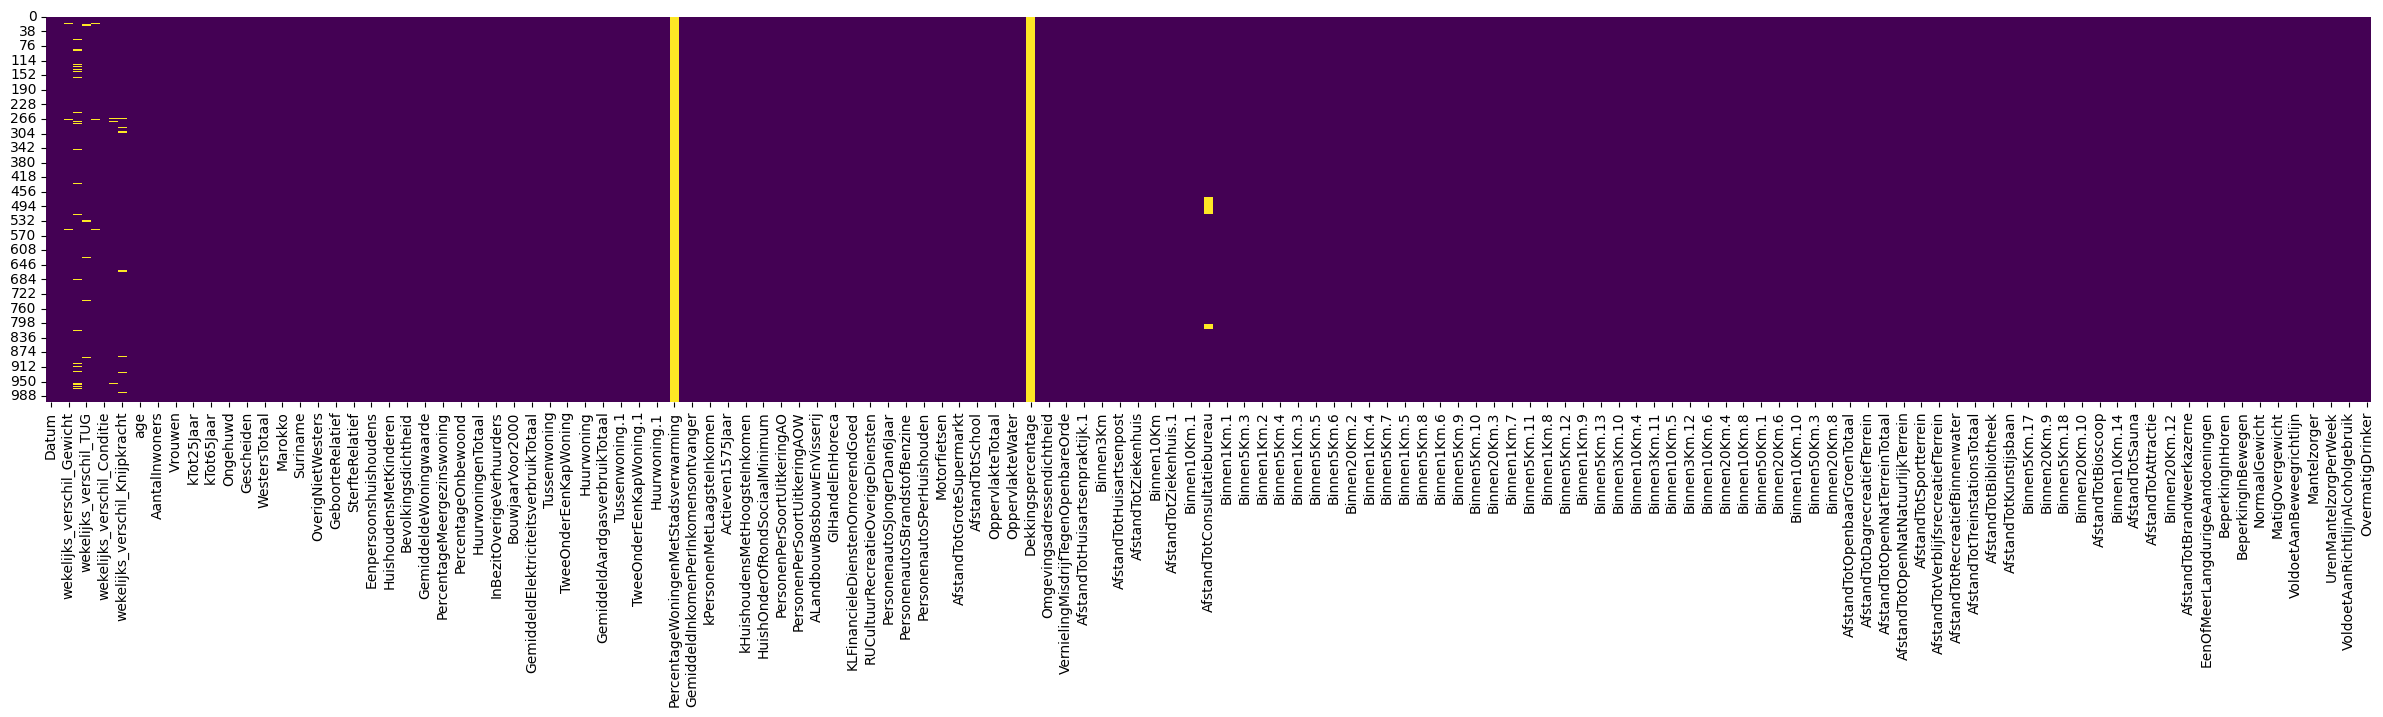

In [24]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_healthylife_cbs.isnull(),cbar=False,cmap='viridis')

In [25]:
# Get all columns with only NaN values
nan_columns = df_healthylife_cbs.columns[df_healthylife_cbs.isna().all()].tolist()
print(nan_columns)

# Remove all columns with only NaN values
df_healthylife_cbs.drop(columns=nan_columns, inplace=True)

['PercentageWoningenMetStadsverwarming', 'Dekkingspercentage']


<Axes: >

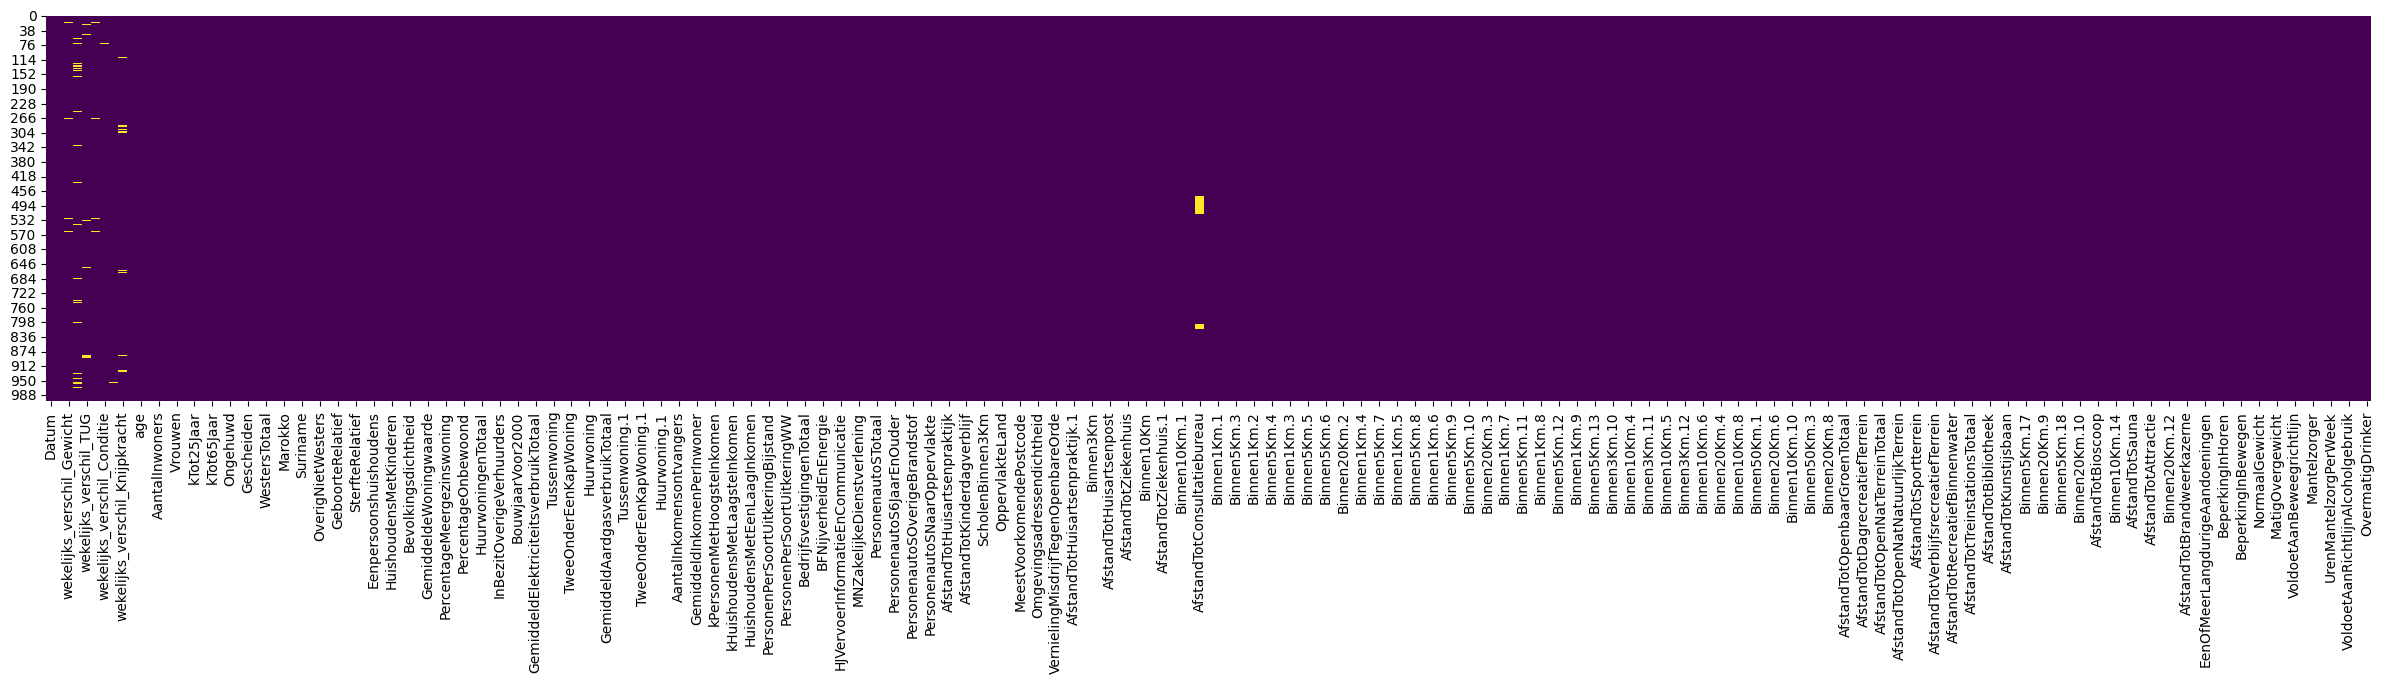

In [26]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_healthylife_cbs.isnull(),cbar=False,cmap='viridis')

In [13]:
# Checking values in columns
for col in rows_with_missing.columns:
    try:
        print('{} : {}'.format(col,rows_with_missing[col].unique()))
    except:
        print(col)

Datum : [2019 2020 2021]
wekelijks_verschil_Lengte : [ 0.         -0.0625      0.05932203  0.22072072  0.26694915]
wekelijks_verschil_Gewicht : [-0.2038835   0.06206897  0.13658537 -0.24756098 -0.04583333 -0.07078652
 -0.26694915 -0.00909091  0.01538462 -0.02727273 -0.2018018  -0.07118644
 -0.22727273 -0.73365385  0.07403846  0.08571429  0.01764706 -0.19411765
 -0.07553957 -0.01510791 -0.00503597 -0.15107914 -0.02014388 -0.01007194
 -0.03021583 -0.41294964 -0.29208633 -0.455      -0.77       -1.5225    ]
wekelijks_verschil_6 MWT : [        nan  0.          5.03658537 -3.41463415  1.25        6.34745763
 -0.38461538  3.68181818 -1.89830508  4.09090909 -4.03846154 -8.
  2.05882353  6.47058824  7.45323741  5.23741007 -7.45323741  4.48201439
  6.1942446   2.26618705  2.21582734  1.76258993  3.37410072  4.07913669
  9.4676259   3.02158273  4.2         4.375       2.625     ]
wekelijks_verschil_TUG : [ 0.01902913 -0.02344828 -0.20487805 -0.09390244  0.0375      0.03932584
 -0.06050847 -0.054

Reduce Columns

In [ ]:
# Drop columns what should not be used as predictor
df_healthylife_cbs.drop(columns=['Gemeente', 'Datum', 'Perioden'], inplace=True)

In [ ]:
# Defining the function that you will run later
#https://github.com/K-Ellis/Neural-Network-Classification-and-Unbalanced-Bank-Marketing-Data/issues/1#issue-234132765
def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print(variables)
    
    return X[[i for i in variables]]

def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores

In [ ]:
#vif scores on all columns
vif_scores(df_healthylife_cbs)

c:\Users\Vincent\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
#remaining columns with vif score lower then 5
ListMulticollinearityVIFTestColumns = []
vif_scores(calculate_vif_(df_healthylife_cbs,5))

239


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


NameError: name 'variance_inflation_factor' is not defined